# Neoclassical transport for an axisymmetric plasma

Currently a work in progress.

# Houlberg_1997

Equation 6:

$$F_\alpha^{ai} = \int m_a v L_{\alpha-1}^{3/2}(x_a^2)C_{ai} dv$$


$$<F_\alpha^{ai} \cdot B> = \sum_{b,j,\beta} l_{\alpha \beta}^{ai, bj} \hat{u}_\beta^{bj}$$


$$l_{\alpha \beta} ^{ai, bj} = \xi_{ai}(\delta_{ai,bj} M_{\alpha\beta}^a + \xi_{bj} N_{\alpha \beta}^{ab})$$

$$\xi_{ai} = n_{ai} Z_i^2 / \sum_i n_{ai} Z_i^2$$

$$\mu_{\alpha \beta}^{ai} = \frac{8}{3 \sqrt\pi} n_{ai} m_a (-1)^{\alpha + \beta} \times \int_0^\infty dx x^4 e^{-x^2} L_{\alpha-1}^{3/2} L_{\beta-1}^{3/2} \bar{K}^{ai}$$

$$\bar{K}^{ai} = K_B K_{PS} / (K_B + K_{PS})$$
(upuściłem superskrypt ai wszędzie);
$K_B, K_{PS}$ zdefiniowane w appendix B

Equation 23:

$$\sum_\beta (\xi_{ai} M^a_{\alpha \beta} - \hat{\mu}^{ai}_{\alpha\beta}) \hat{\mu}_\beta^{ai} - (\beta_{cx,a} + \beta_{an,\alpha}) \hat{u}_\alpha^{ai} 
= 
- \xi_{ai} =\sum_\beta \sum_b N^{ab}_{\alpha \beta} \bar{\mu}_\beta^b + \sum_\beta \hat{\mu}_{\alpha\beta}^{ai}S_{\theta,\beta}^{ai} - S_{E_\parallel,\alpha}^{ai} - S_{NBI\parallel, \alpha}^{ai}$$

$$\bar{\mu}_\beta^b = \sum_j \xi_{bj} \hat{\mu}_\beta^{bj}$$

Eventually we can go back to $$D^{C,\alpha} = \frac{- \Gamma^{C,\alpha}}{n_c \nabla(\ln \alpha)}$$

for $\alpha \in \{ T_e, T_i, n_e, n_D, n_C \}$

Eq. 41a:

$$\Gamma_{BP}^{ai} = -\hat{F} e_{ai}^{-1} \sum_\beta \hat{\mu}_{1\beta}^{ai} \hat{u}_{\theta,\beta}^{ai}$$

And the other gammas... around eq. 43

TODO assume we can skip heat flows for now. That's 41b

In [1]:
from plasmapy.particles import IonizationStateCollection

all_species = IonizationStateCollection(
    {
        "H": [0, 1],
        #      "D": [0, 1],   raises ParticleError, why?
        "C": [0, 0, 0, 0, 0, 0, 1],
    },
    n0=1e20 * u.m ** -3,
    abundances={"H": 1, "C": 0.08},
    T_e=10 * u.eV,
)
all_species["H"].n_e

<Quantity 1.e+20 1 / m3>

In [2]:
h1 = all_species["H"][1]
h1.number_density, h1.T_i

(<Quantity 1.e+20 1 / m3>, <Quantity 116045.1812155 K>)

# Flux surface

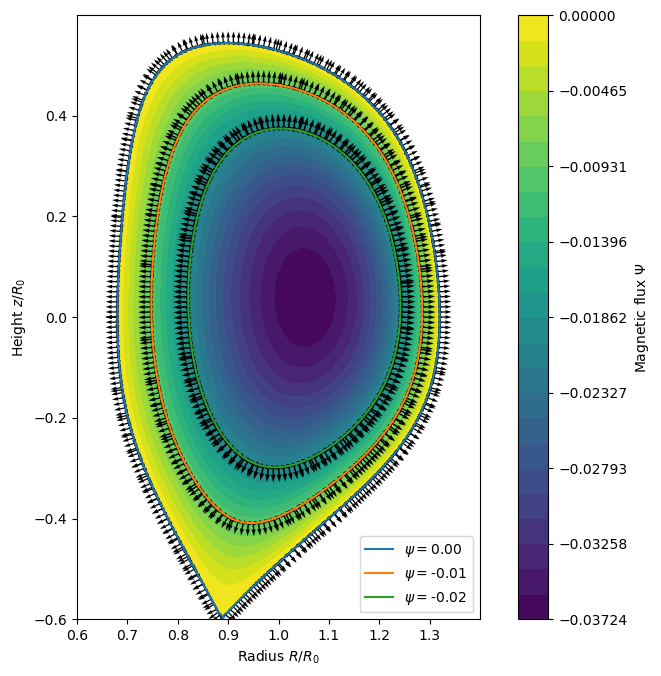

In [3]:
import plasmaboundaries

from plasmapy.plasma.symbolicequilibrium import SymbolicEquilibrium

params = plasmaboundaries.ITER.copy()
assert params["triangularity"] <= 0.841  # for convex plasma surfaces
eq = SymbolicEquilibrium(**params, B0=5.2, config="single-null")
ax = eq.plot((0.6, 1.4, 0.001), (-0.6, 0.6, 0.001), vmax=-0)
for psi_value in [0, -0.01, -0.02]:
    fs = eq.get_flux_surface(psi_value)
    fs.plot(ax, B=True, n=True)

## On a grid

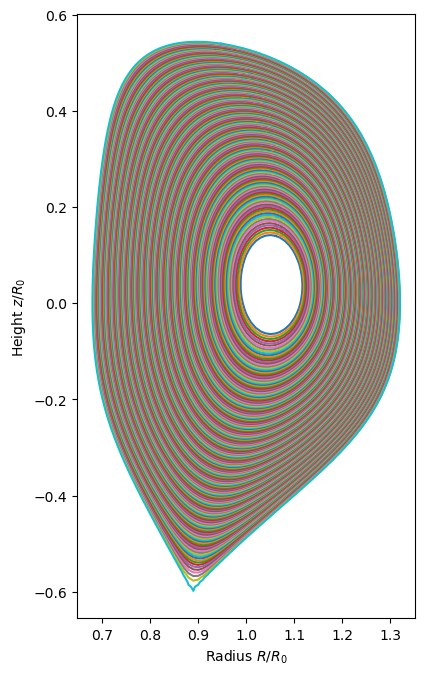

In [4]:
levels = np.linspace(-0.03556, 0, 200)
surfaces = {level: eq.get_flux_surface(level) for level in levels}

# ax = eq.plot()
ax = None
for fs in surfaces.values():
    ax = fs.plot(ax, legend=False)

## One particular surface

<AxesSubplot:xlabel='Radius $R/R_0$', ylabel='Height $z/R_0$'>

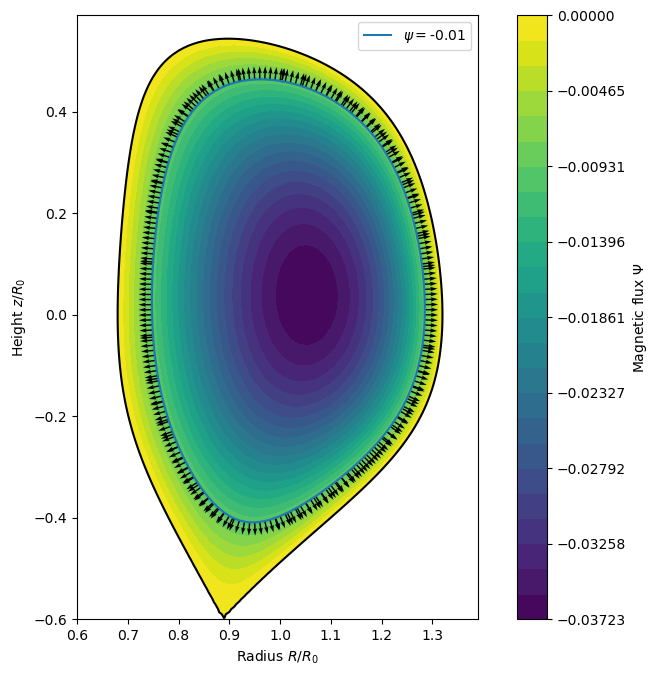

In [5]:
ax = eq.plot()
fs = eq.get_flux_surface(-0.01)
fs.plot(ax, n=True)

In [6]:
fs.trapped_fraction()

0.5179670516625869

# Steady state force balance model

## TODO Viscosity coefficients

eq. 15

In [7]:
a = all_species["H"]
ai = a[1]

IonicLevel('H 1+', ionic_level=1.0)

### ????

In [8]:
import sympy

LaguerrePolynomials = [
    lambda x: 1,
    lambda x: 5 / 2 - x,
    lambda x: 35 / 8 - 7 / 2 * x + 1 / 2 * x ** 2,
]

x = sympy.symbols("x")


def K(ai, x, *args, **kwargs):
    return 1  # TODO


orders = range(1, 4)

mu_hat_ai = sympy.Matrix(np.zeros((3, 3)))

π = sympy.pi
for α in orders:
    for β in orders:
        integrand = (
            x ** 4
            * sympy.exp(-(x ** 2))
            * LaguerrePolynomials[α - 1](x ** 2)
            * LaguerrePolynomials[β - 1](x ** 2)
            * K(ai, x)
        )
        integral = sympy.integrate(integrand, (x, 0, sympy.oo))
        mass_density_probably = (ai.number_density * ai.ion.mass).si.value
        value = (
            8 / 3 / sympy.sqrt(π) * integral * (-1) ** (α + β) * mass_density_probably
        )
        mu_hat_ai[α - 1, β - 1] = value
mu_hat_ai

Matrix([
[1.67291244076265e-7,                   0,                   0],
[                  0, 4.18228110190663e-7,                   0],
[                  0,                   0, 7.31899192833659e-7]])

## Reduced charge state solution

> When Eq. ~1! is expressed in terms of the parallel flows
using Eq. ~19! to eliminate the poloidal flows# and the sums
over the charge states j for species b are carried out, we
obtain a set of three equations ( a = 1,2,3) for each charge
state of each isotope,

$$\sum_\beta (\xi_{ai} M^a_{\alpha \beta} - \hat{\mu}^{ai}_{\alpha\beta}) \hat{\mu}_\beta^{ai} - (\beta_{cx,a} + \beta_{an,\alpha}) \hat{u}_\alpha^{ai} 
= 
- \xi_{ai} =\sum_\beta \sum_b N^{ab}_{\alpha \beta} \bar{\mu}_\beta^b + \sum_\beta \hat{\mu}_{\alpha\beta}^{ai}S_{\theta,\beta}^{ai} - S_{E_\parallel,\alpha}^{ai} - S_{NBI\parallel, \alpha}^{ai}$$

$$\bar{\mu}_\beta^b = \sum_j \xi_{bj} \hat{\mu}_\beta^{bj}$$

So we take the general equation (25)

$$A^{ai} \cdot \hat{u}^{ai} = \xi_{ai} \Lambda^a (\bar{u}^b) + S^{ai}$$

This means every charge level has

- [x] an $A^{ai}$ 3x3 matrix (28) using
    - [x] script M
    - [ ] viscosities $\hat{\mu}_{\alpha\beta}^{ai}$
    - [x] the charge weight $\xi_{ai}$
    - [ ] beta coefficients
- [ ] the $\Lambda^a$ term which depends on the isotope only and involves script N and $\hat{u}_\beta^b$, summed over beta and b

In [9]:
from plasmapy.formulary import neoclassical

In [10]:
ai = a[1]

IonicLevel('H 1+', ionic_level=1.0)

In [11]:
def ξ(isotope):
    array = u.Quantity(
        [ai.number_density * ai.ion.integer_charge ** 2 for ai in isotope]
    )
    return array / array.sum()

In [12]:
ξ(all_species["H"])

<Quantity [0., 1.]>

In [13]:
i = 1
ξ(a)

<Quantity [0., 1.]>

In [14]:
neoclassical.M_script(a, all_species)

<Quantity [[-1.24272503,  1.55262355, -1.68605372],
           [ 1.55262355,  4.0043251 ,  4.64681939],
           [-1.68605372,  4.64681939, -7.80400786]] kg / (m3 s)>

In [15]:
def mu_hat(ai, *args, **kwargs):
    return np.zeros((3, 3))  # TODO

In [16]:
beta_cx = np.zeros(3)  # TODO
beta_an = np.zeros(3)  # TODO
beta_coeffs = np.diag(beta_cx + beta_an)

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [17]:
Aai = ξ(a)[i] * neoclassical.M_script(a, all_species) - mu_hat(ai) - beta_coeffs

<Quantity [[-1.24272503,  1.55262355, -1.68605372],
           [ 1.55262355,  4.0043251 ,  4.64681939],
           [-1.68605372,  4.64681939, -7.80400786]] kg / (m3 s)>

The really key equation seems to be $A^{ai} \cdot \hat{r}^{ai}_m = S^{ai}_m$, where m is the force source (1, 2, 3, pT, E, NBI and we can neglect the latter two for the first approximation);

$S^{ai}_\alpha$ here being just $\xi_{ai} \hat{e}_\alpha$, the charge weight times a unit vector

We can then do a bunch of inversions and get the $\hat{r}_m^{ai}$'s, and then combine them via the $\Lambda_i$-weighted linear combination of equation 31 into the whole charge state flow $\hat{u}^{ai}$.

But this still does not seem to be what they do. Instead they multiply (31) by $\xi_{ai}$ and sum those over the charge states. This basically replaces the $(ai)$ species indices with $a$ isotope indices.

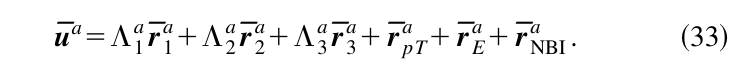

Then they go back to 27

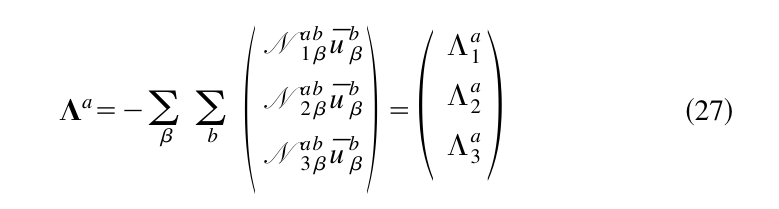

Essentially to back-substitute the $\Lambda^a_i$s, and they get "a linear set of 3n equations for three parallel flow components for the n isotopes",

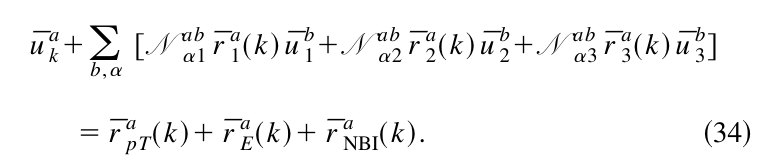

**This** is the equation that gets solved, and the one to tackle the ingredients of next.

And then they get the flows for each charge state using

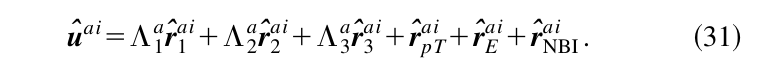

## Particle (and heat) fluxes

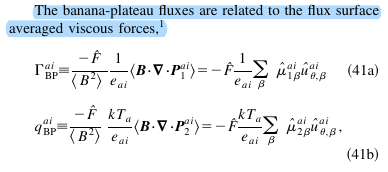

Note how they use here the $\hat{\mu}$ coefficients and the reconstructed flow velocities $\hat{\mu}^{ai}$. To get the poloidal flow velocities, they use eq. 19 and the ones following:

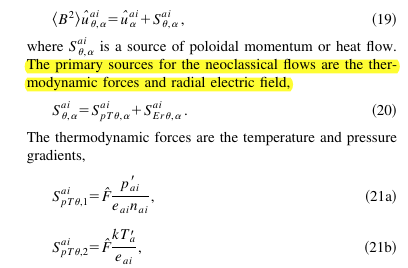

Meanwhile,

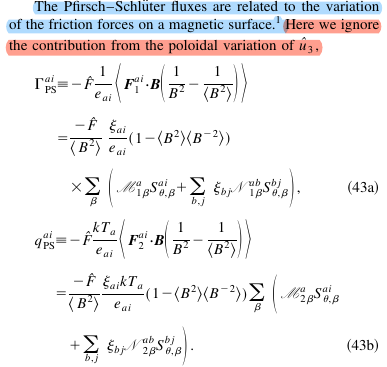

Note how this absolutely does not depend on the velocities. I could in fact probably start coding it up now, except for the $S_{\theta,\beta}^{ai}$ term, which is... the poloidal momentum/heat flow source from eq. 19 and following. Coolio.

Meanwhile, for the classical terms:

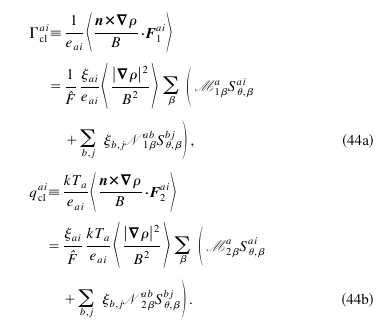

Mostly dependence on the script matrices, once again the poloidal source

In [18]:
ai = a[1]
# Houlberg_1997, eq. 41a
def beta_sum():
    for i in range(3):
        yield i
        # yield mu^hat_1_beta^ai * u^hat_theta,beta^ai


Flux_BP_ai = -fs.Fhat / ai.ion.charge * sum(beta_sum())

<Quantity -6.45312661e+20 1 / C>

# Appendix A

In [19]:
from plasmapy.formulary.neoclassical import L_friction_coefficient

In [20]:
L_friction_coefficient(a, 1, a, 1, all_species)  # TODO refactor

<Quantity [[-0.97904549,  1.35486389, -1.56245393],
           [ 1.35486389,  4.44928433,  4.18332019],
           [-1.56245393,  4.18332019, -7.12807152]] kg / (m3 s)>

# Appendix B

## Trapped fraction

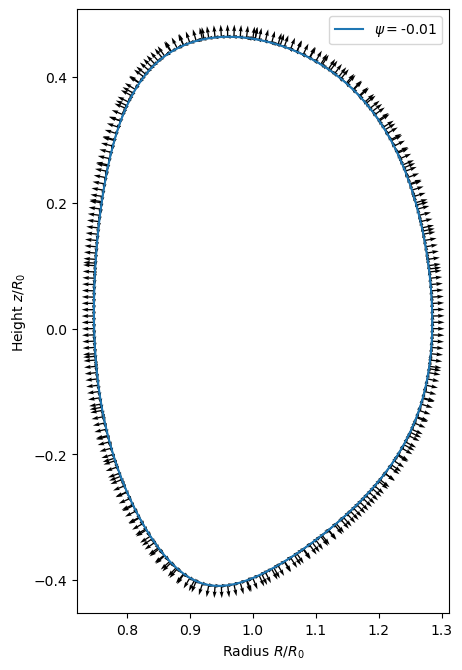

In [21]:
fs.plot(n=True, B=True);

In [22]:
trapped_fractions = {}
for psi_value, fs in surfaces.items():
    trapped_fractions[psi_value] = {
        "f_tl": fs._f_tl,
        "f_tu": fs._f_tu,
        "f_t": fs.trapped_fraction(),
    }
import pandas as pd

df = pd.DataFrame(trapped_fractions).T

,f_tl,f_tu,f_t
-0.035560,-0.146881,0.353904,0.228708
-0.035381,-0.138302,0.361866,0.236824
-0.035203,-0.129445,0.369658,0.244883
-0.035024,-0.121832,0.376675,0.252049
-0.034845,-0.114229,0.383322,0.258935
...,...,...,...
-0.000715,0.221523,0.665191,0.554274
-0.000536,0.223361,0.665985,0.555329
-0.000357,0.224630,0.666390,0.555950
-0.000179,0.226914,0.666989,0.556970


<AxesSubplot:>

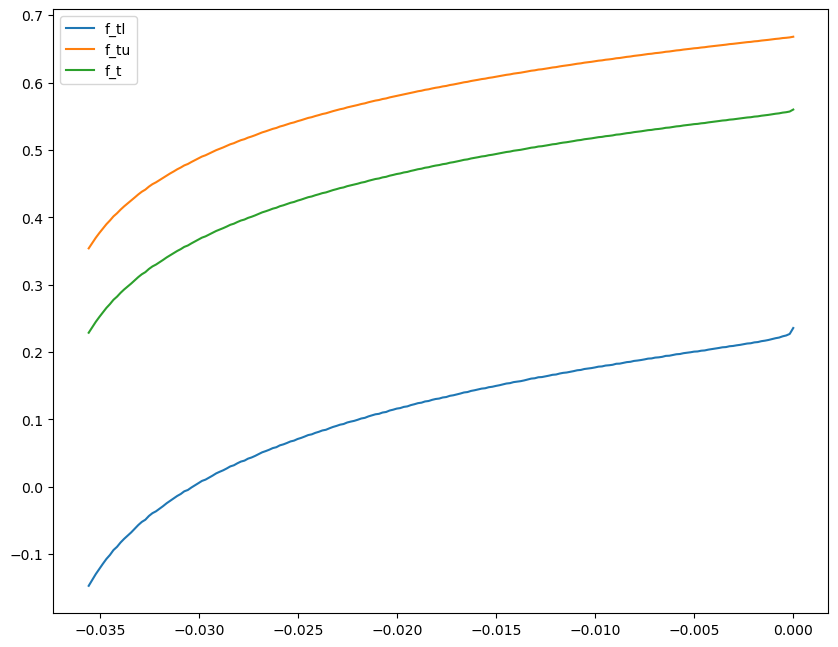

In [23]:
df.plot()

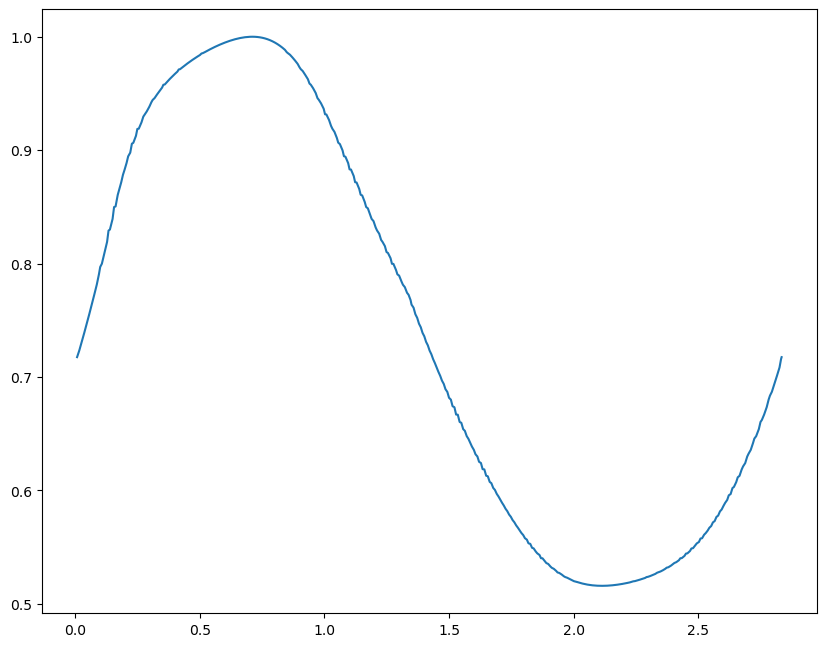

In [24]:
h = fs.Bmag / fs.Bmax
plt.plot(fs.lp, h)

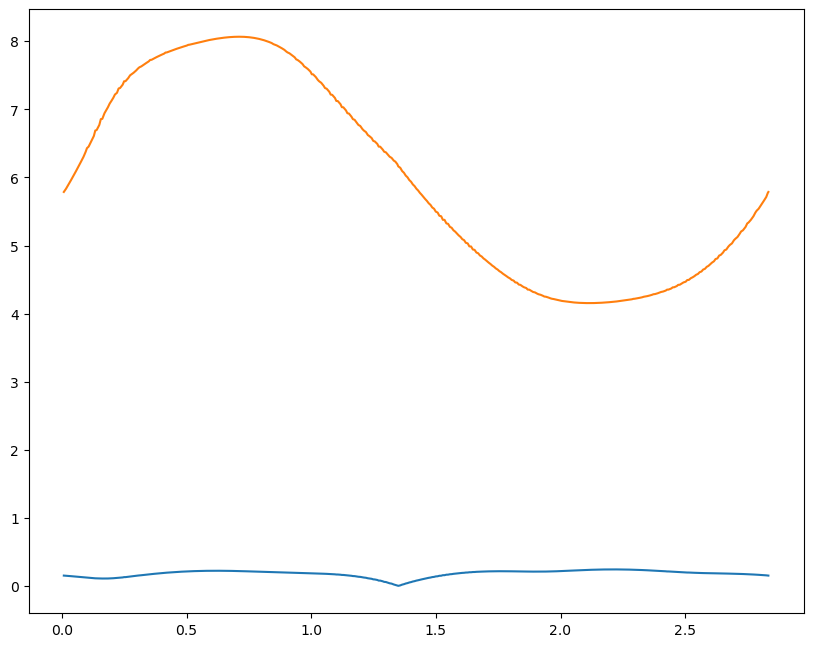

In [25]:
plt.plot(fs.lp, fs.Bp)
plt.plot(fs.lp, fs.Bphivals)

In [26]:
hmean = fs.flux_surface_average(h)

0.7564374751405418

In [27]:
h2mean = fs.flux_surface_average(h ** 2)

0.5940455418510815

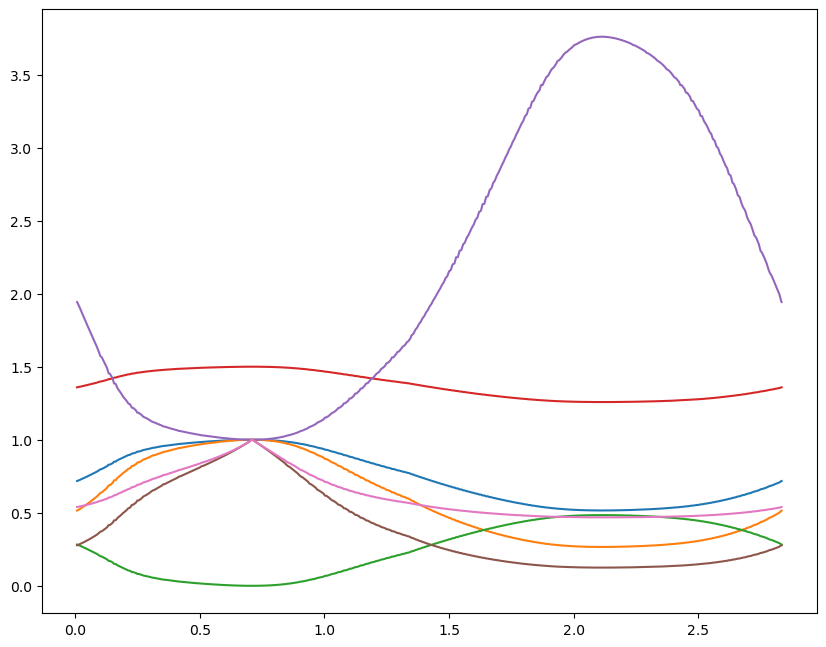

In [28]:
plt.plot(fs.lp, h),
plt.plot(fs.lp, h ** 2)
plt.plot(fs.lp, 1 - h)
plt.plot(fs.lp, 1 + h / 2)
plt.plot(fs.lp, h ** -2)
plt.plot(fs.lp, (1 - (1 - h) ** 0.5 * (1 + h / 2)))
plt.plot(fs.lp, (1 - (1 - h) ** 0.5 * (1 + h / 2)) / h ** 2)

In [29]:
f_tu = 1 - h2mean / hmean ** 2 * (1 - (1 - hmean) ** 0.5 * (1 + hmean / 2))
f_tl = 1 - h2mean * fs.flux_surface_average(
    h ** -2 * (1 - (1 - h) ** 0.5) * (1 + h / 2)
)
f_tu, f_tl, (f_tu - f_tl) / f_tl

(0.667967729454466, 0.23571654692135613, 1.8337753041890823)

In [30]:
if not (f_tu - f_tl) / f_tl < 0.1:
    print(f_tu, f_tl, (f_tu - f_tl) / f_tl)

0.667967729454466 0.23571654692135613 1.8337753041890823


## Pfirsch-Schlueter contribution

0.012864105357948555

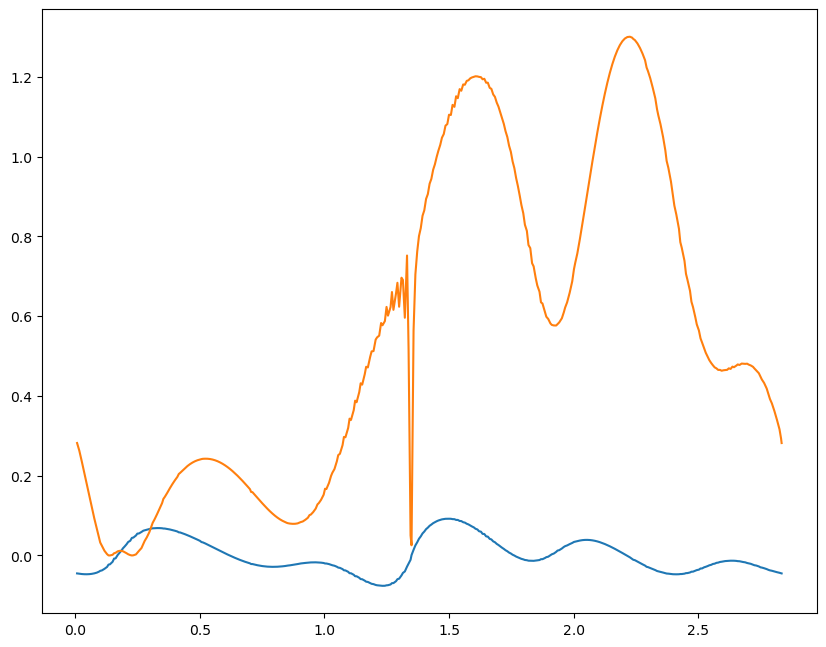

In [31]:
Theta = fs.Theta
B20 = fs.Brvals * fs.Bprimervals + fs.Bzvals * fs.Bprimezvals
plt.plot(fs.lp, B20)

# B17
Bprimevectors = np.stack((fs.Bprimervals, fs.Bprimezvals))

under_average_B17 = np.array(
    [np.dot(ni, Bpi) ** 2 for (ni, Bpi) in zip(fs.n.T, Bprimevectors.T)]
)
plt.plot(fs.lp, under_average_B17)
B2mean = fs.flux_surface_average(fs.B2)
B17 = fs.flux_surface_average(under_average_B17) / B2mean

### F_m and its unknown values

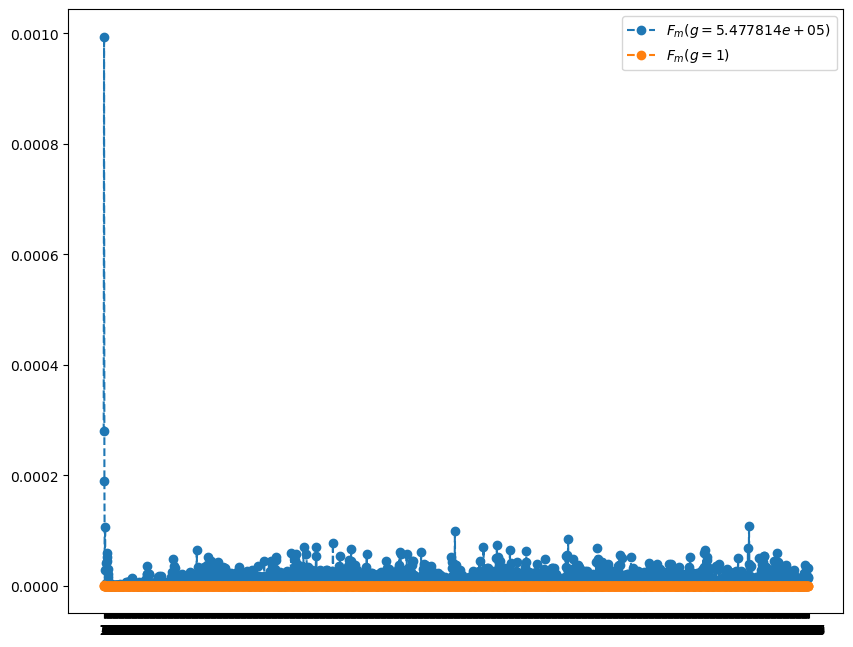

In [32]:
num_m = 1000


def F_m(m, g=1):
    if g == 0:
        return np.nan
    under_average_B16 = np.sin(m * Theta) * B20
    under_average_B15 = under_average_B16 / fs.Bmag
    under_average_B16_cos = np.cos(m * Theta) * B20
    under_average_B15_cos = under_average_B16_cos / fs.Bmag
    #     plt.plot(fs.lp, under_average_B15)
    #     plt.plot(fs.lp, under_average_B16)
    B15 = fs.flux_surface_average(under_average_B15)
    B16 = fs.gamma * fs.flux_surface_average(under_average_B16)
    B15_cos = fs.flux_surface_average(under_average_B15_cos)
    B16_cos = fs.gamma * fs.flux_surface_average(under_average_B16_cos)

    jacobian = g ** 0.5
    BdotNablatheta = 1 / (2 * np.pi) / jacobian  # NotImplemented # see right after B14
    F_m = B9 = 2 / B2mean / BdotNablatheta * (B15 * B16 + B15_cos * B16_cos)
    return F_m


def optimizer(g):
    mrange = range(1, num_m)
    F_ms = np.array([F_m(m, g) for m in mrange])
    diff = F_ms.sum() - B17
    return diff ** 2


from scipy import optimize

optimization = optimize.minimize_scalar(optimizer)
mrange = range(1, 2 * num_m)
F_ms = np.array([F_m(m, optimization.x) for m in mrange])
plt.plot(F_ms, "o--", label=fr"$F_m(g={optimization.x:e})$")
plt.plot(np.array([F_m(m, 1) for m in mrange]), "o--", label=r"$F_m(g=1)$")
plt.xticks(mrange)
plt.legend()

In [33]:
cumsum = np.cumsum(F_ms)

array([0.00027985, 0.00127368, 0.00146381, ..., 0.02554103, 0.02557231,
       0.02558597])

In [34]:
cumsum - B17

array([-0.01258426, -0.01159042, -0.01140029, ...,  0.01267693,
        0.01270821,  0.01272187])

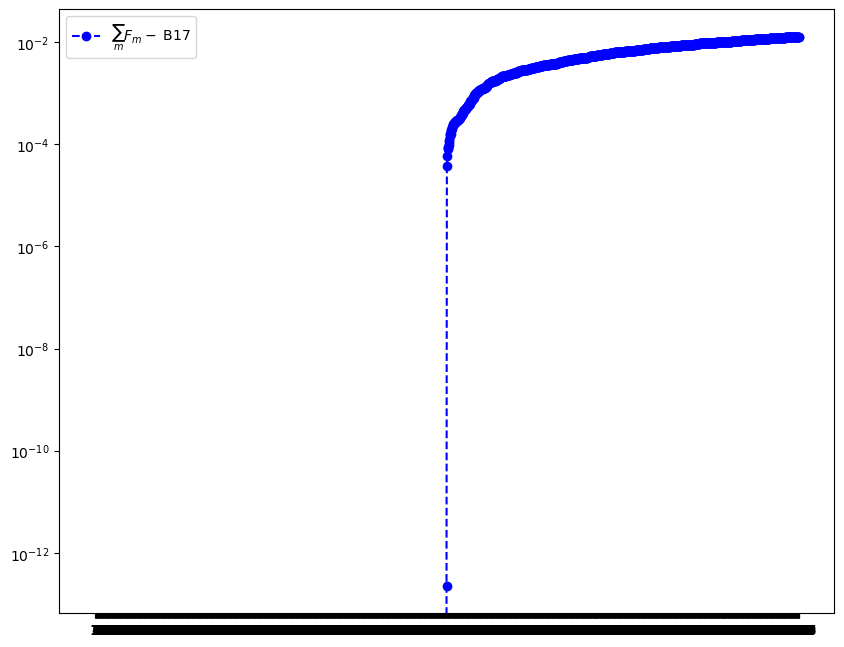

In [35]:
plt.plot(cumsum - B17, "bo--", label=r"$\sum_m F_m -$ B17")
# plt.axhline(0, color="black"
#            )
plt.yscale("log")
plt.xticks(mrange)
plt.legend()

So this probably sucks as a solution, a little.

In [36]:
from plasmapy.formulary import thermal_speed

In [37]:
a.T_e

<Quantity 116045.1812155 K>

In [38]:
from astropy import constants

In [39]:
thermal_speed(a.T_e, a._particle)

<Quantity 43753.75996466 m / s>

In [40]:
from __future__ import annotations


def ω(x, m, a: isotopelike, fs):
    B11 = x * thermal_speed(a.T_e, a._particle) * m * fs.gamma
    # TODO not sure about the m * gamma part...
    return B11

In [41]:
ω(1, 1, a, fs)

<Quantity 2186.71414523 m / s>